# Forecasting

The following sections detail the econometric and machine learning pipeline used to evaluate the predictive utility of the INSEI sentiment index against the official Consumer Price Index (CPI). 

The analysis employs a "Control vs. Test" experimental design, comparing baseline models (using only historical inflation data) against hybrid models (using historical inflation + news sentiment) across three distinct architectures: Ridge Regression, Vector Autoregression (VAR), and Long Short-Term Memory (LSTM).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(42)
np.random.seed(42)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
def calculate_metrics(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"--- {model_name} ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
    print("-" * 30)
    
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R2": r2}

results_summary = []

# Data Load & Split

In [2]:
# Load the Aligned Data (Created in File 8)
df = pd.read_csv("insei_all_model_cpi_aligned_lag2.csv")
df["year_month_dt"] = pd.to_datetime(df["year_month_dt"])
df = df.set_index("year_month_dt")

# Define Columns
TARGET_COL = "Rate"
SENTIMENT_COLS = ["insei_indobert_final", "insei_indolem_final", "insei_mdeberta_final","insei_gemini_final"]

# Split Train/Test
CUTOFF_DATE = "2024-01-01"
train_df = df[df.index < CUTOFF_DATE].copy()
test_df = df[df.index >= CUTOFF_DATE].copy()

print(f"Training Samples: {len(train_df)} (Jan 2017 - Dec 2023)")
print(f"Testing Samples:  {len(test_df)}  (Jan 2024 - Oct 2025)")

Training Samples: 82 (Jan 2017 - Dec 2023)
Testing Samples:  22  (Jan 2024 - Oct 2025)


In [3]:
df.head()

,year_month_str,Rate,insei_indobert_final,insei_indolem_final,insei_mdeberta_final,insei_gemini_final
year_month_dt,,,,,,
2017-03-01,2017-03,-0.02,50.0,50.0,50.0,50.0
2017-04-01,2017-04,0.09,50.0,50.0,50.0,50.0
2017-05-01,2017-05,0.39,50.0,50.0,50.0,50.0
2017-06-01,2017-06,0.69,50.0,50.0,50.0,50.0
2017-07-01,2017-07,0.22,50.0,50.0,50.0,50.0


Loads the aligned dataset insei_all_model_cpi_aligned_lag2.csv, which contains monthly observations of the CPI Inflation Rate and the corresponding 2-month lagged sentiment indices from four models (IndoBERT, IndoLEM, mDeBERTa, Gemini). 

The date column is converted to a datetime object and set as the index. A  temporal split is defined using CUTOFF_DATE = "2024-01-01".
- Training Set (2017–2023): 82 months (Jan 2017 – Dec 2023) period covers pre-pandemic stability, the COVID-19 shock, and the initial recovery. Used to fit model parameters.
- Testing Set (2024–2025): This forecast horizon tests the models' ability to generalize to the most recent economic conditions. Used solely for out-of-sample evaluation.


# Var

In [ ]:
# Define a separate function just for the Baseline
def run_baseline_ar(train, test):
    ar_model = AutoReg(train[TARGET_COL].dropna(), lags=12, old_names=False).fit()
    
    pred_start = len(train)
    pred_end = len(train) + len(test) - 1
    preds_base = ar_model.predict(start=pred_start, end=pred_end, dynamic=False).values
    
    test_clean = test[TARGET_COL].iloc[-len(preds_base):]
    # Calculate and PRINT metrics only once
    return calculate_metrics(test_clean, preds_base, "VAR_Baseline_AR_Only")

# Modify comparison function to ACCEPT the baseline metrics
def run_var_hybrid_only(train, test, sentiment_col, baseline_metrics):
    #  SCENARIO B: Hybrid (Bi-variate VAR) 
    cols = [TARGET_COL, sentiment_col]
    train_var = train[cols].dropna()
    test_var = test[cols].dropna()
    
    model = VAR(train_var)
    model_fitted = model.fit(maxlags=12, ic='bic')    
    lag_order = model_fitted.k_ar
    
    history = train_var.values[-lag_order:].tolist()
    predictions = []
    
    for i in range(len(test_var)):
        input_data = np.array(history[-lag_order:])
        fc = model_fitted.forecast(y=input_data, steps=1)
        predictions.append(fc[0][0])
        history.append(test_var.iloc[i].values)
        
    metrics_hyb = calculate_metrics(test_var[TARGET_COL], predictions, f"VAR_Hybrid_{sentiment_col}")
    
    # Compare with the pre-calculated baseline
    imp = baseline_metrics['RMSE'] - metrics_hyb['RMSE']
    print(f"VAR Improvement with {sentiment_col}: {imp:.4f}")
    
    return metrics_hyb

baseline_metrics = run_baseline_ar(train_df, test_df)
results_summary.append(baseline_metrics)

for sent in ["insei_indobert_final","insei_indolem_final", "insei_mdeberta_final","insei_gemini_final"]:
    hyb_metrics = run_var_hybrid_only(train_df, test_df, sent, baseline_metrics)
    results_summary.append(hyb_metrics)

c:\Users\Lenovo\.conda\envs\tensorflow_FINAL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\.conda\envs\tensorflow_FINAL\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Lenovo\.conda\envs\tensorflow_FINAL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\.conda\envs\tensorflow_FINAL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freque

--- VAR_Baseline_AR_Only ---
MAE:  0.3503
RMSE: 0.5012
R2:   -0.0055
------------------------------
--- VAR_Hybrid_insei_indobert_final ---
MAE:  0.3494
RMSE: 0.4997
R2:   0.0006
------------------------------
VAR Improvement with insei_indobert_final: 0.0015
--- VAR_Hybrid_insei_indolem_final ---
MAE:  0.3484
RMSE: 0.4969
R2:   0.0115
------------------------------
VAR Improvement with insei_indolem_final: 0.0042
--- VAR_Hybrid_insei_mdeberta_final ---
MAE:  0.3480
RMSE: 0.4962
R2:   0.0142
------------------------------
VAR Improvement with insei_mdeberta_final: 0.0049
--- VAR_Hybrid_insei_gemini_final ---
MAE:  0.3495
RMSE: 0.4963
R2:   0.0140
------------------------------
VAR Improvement with insei_gemini_final: 0.0049


c:\Users\Lenovo\.conda\envs\tensorflow_FINAL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


VAR is a system of equations where every variable is "endogenous" (they all influence each other). This is crucial because Inflation affects Sentiment, and Sentiment affects Inflation.
- The System of Equations:Let $Y_t$ be a vector containing both variables: $Y_t = \begin{bmatrix} \text{Rate}_t \\ \text{Sentiment}_t \end{bmatrix}$.The VAR(p) model is:$$Y_t = c + A_1 Y_{t-1} + A_2 Y_{t-2} + \dots + A_p Y_{t-p} + e_t$$
Where $A_k$ are $2 \times 2$ coefficient matrices. Written out for Inflation ($y_t$):$$y_t = c_1 + \sum_{k=1}^{p} a_{11,k} y_{t-k} + \sum_{k=1}^{p} a_{12,k} S_{t-k} + e_{1,t}$$
- Unlike Ridge, VAR captures the feedback loop. It understands that a shock to Sentiment today might raise Inflation tomorrow, which in turn scares the public and lowers Sentiment further.

The experiment follows a rigorous Baseline vs. Hybrid design:
- Baseline (AutoReg): A univariate Autoregressive model is trained solely on the Rate column using AutoReg. It predicts the test set using only historical inflation inertia. This serves as the control group.
- Hybrid (Bi-variate VAR): A Vector Autoregression model is trained on both Rate and the specific sentiment_col. The model order (lag length) is automatically selected using the Bayesian Information Criterion (BIC) to prevent overfitting. The forecast is generated using a rolling window approach, where the model uses the actual observed history (teacher forcing) to predict one step ahead for the entire test period.

Baseline Performance: The AR model yields an RMSE of 0.5012.

Hybrid Performance: The hybrid models consistently outperform the baseline. Specifically, the mDeBERTa-based VAR achieves the lowest RMSE of 0.4962, representing a reduction in error of 0.0049.(<1%)

Even though absolute improvement is small, the positive reduction in RMSE across all hybrid models confirms that the news sentiment index adds valuable predictive signal that is orthogonal to past inflation data.

# Ridge

In [5]:
def create_lags(data, sent_col=None, lags=12):
    df_lag = pd.DataFrame()
    # A. Autoregressive Features
    for i in range(1, lags + 1):
        df_lag[f"Rate_L{i}"] = data[TARGET_COL].shift(i)
        
    # B. Sentiment Features (Only if sent_col is provided)
    if sent_col: 
        for i in range(1, lags + 1):
            df_lag[f"Sent_L{i}"] = data[sent_col].shift(i)
            
    df_lag["Target"] = data[TARGET_COL]
    return df_lag.dropna()

def run_ridge_baseline(train, test, lags=12):
    # Prepare Data (No sentiment col passed)
    train_feats = create_lags(train, sent_col=None, lags=lags)
    test_feats = create_lags(test, sent_col=None, lags=lags)
    
    X_train = train_feats.drop("Target", axis=1)
    y_train = train_feats["Target"]
    X_test = test_feats.drop("Target", axis=1)
    y_test = test_feats["Target"]
    
    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Train & Predict
    model = RidgeCV(cv=5).fit(X_train_s, y_train)
    preds = model.predict(X_test_s)
    
    return calculate_metrics(y_test, preds, "Ridge_Baseline_AR_Only")

def run_ridge_hybrid(train, test, sentiment_col, baseline_metrics, lags=12):
    # Prepare Data (With Sentiment)
    train_feats = create_lags(train, sentiment_col, lags)
    test_feats = create_lags(test, sentiment_col, lags)
    
    X_train = train_feats.drop("Target", axis=1)
    y_train = train_feats["Target"]
    X_test = test_feats.drop("Target", axis=1)
    y_test = test_feats["Target"]
    
    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Train & Predict
    model = RidgeCV(cv=5).fit(X_train_s, y_train)
    preds = model.predict(X_test_s)
    
    metrics_hyb = calculate_metrics(y_test, preds, f"Ridge_Hybrid_{sentiment_col}")
    
    # Compare
    imp = baseline_metrics['RMSE'] - metrics_hyb['RMSE']
    print(f"Ridge Improvement with {sentiment_col}: {imp:.4f}")
    
    return metrics_hyb

ridge_base_metrics = run_ridge_baseline(train_df, test_df)
results_summary.append(ridge_base_metrics)

for sent in ["insei_indobert_final", "insei_indolem_final", "insei_mdeberta_final", "insei_gemini_final"]:
    hyb = run_ridge_hybrid(train_df, test_df, sent, ridge_base_metrics)
    results_summary.append(hyb)

--- Ridge_Baseline_AR_Only ---
MAE:  0.6264
RMSE: 0.7560
R2:   -0.1794
------------------------------
--- Ridge_Hybrid_insei_indobert_final ---
MAE:  0.6223
RMSE: 0.7446
R2:   -0.1440
------------------------------
Ridge Improvement with insei_indobert_final: 0.0115
--- Ridge_Hybrid_insei_indolem_final ---
MAE:  0.6014
RMSE: 0.7192
R2:   -0.0672
------------------------------
Ridge Improvement with insei_indolem_final: 0.0369
--- Ridge_Hybrid_insei_mdeberta_final ---
MAE:  0.6006
RMSE: 0.7226
R2:   -0.0776
------------------------------
Ridge Improvement with insei_mdeberta_final: 0.0334
--- Ridge_Hybrid_insei_gemini_final ---
MAE:  0.6157
RMSE: 0.7370
R2:   -0.1209
------------------------------
Ridge Improvement with insei_gemini_final: 0.0190


Ridge Regression (Linear Baseline vs. Hybrid)

Ridge is a regularized linear model. It works by shrinking coefficients ($\beta$) to prevent overfitting, which is critical when you have many correlated lags (e.g., Lag 1 is highly correlated with Lag 2).
- The Objective Function: Ridge minimizes the Sum of Squared Errors (SSE) plus a penalty term ($\lambda$) for the size of the coefficients:$$\hat{\beta} = \arg\min_{\beta} \left( \sum_{t=1}^{T} (y_t - \hat{y}_t)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 \right)$$
- Scenario A: AR Baseline (Control). The model predicts inflation ($y_t$) using only its own past values ($y_{t-k}$):$$y_t = \alpha + \sum_{k=1}^{12} \beta_k y_{t-k} + \epsilon_t$$
- Scenario B: Hybrid Model (Test). The model includes the Sentiment Index ($S_{t-k}$) as an exogenous regressor:$$y_t = \alpha + \sum_{k=1}^{12} \beta_k y_{t-k} + \sum_{k=1}^{12} \gamma_k S_{t-k} + \epsilon_t$$

- If $\gamma_k \neq 0$ and the error decreases, sentiment provides linear information gain.

The create_lags function transforms the time-series problem into a supervised regression format. It generates 12 lags for the Inflation Rate ($Rate_{t-1} \dots Rate_{t-12}$) and, for the hybrid models, 12 lags for the Sentiment Index.
- Baseline: Uses only the 12 Rate lags as features.
- Hybrid: Uses 12 Rate lags + 12 Sentiment lags.
- Model: RidgeCV is used with 5-fold cross-validation to automatically select the optimal regularization strength ($\alpha$), effectively handling the high correlation between lagged features. Standard scaling is applied to all features to ensure the regularization penalty is applied uniformly.

The Ridge results highlight a significant performance gain:
- Baseline RMSE: 0.7560.
- Hybrid (IndoLEM) RMSE: 0.7192.
- Improvement: The inclusion of IndoLEM sentiment reduced the RMSE by 0.0369. (3%)

The linear models benefited most from the sentiment data. The substantial drop in error suggests that news sentiment helps correct the linear projections of inflation, likely by capturing "shocks" that purely autoregressive features miss.

# LSTM

In [6]:
LOOKBACK = 12
EPOCHS = 50
BATCH_SIZE = 16

In [7]:
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback, 0]) # 0 is always Rate
    return np.array(X), np.array(y)

# Generic training function
def train_predict_lstm(train, test, feature_cols, model_name):
    # Data Prep
    train_data = train[feature_cols].values
    test_data = test[feature_cols].values
    
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    
    X_train, y_train = create_sequences(train_scaled, LOOKBACK)
    n_features = len(feature_cols)
    
    # Model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(LOOKBACK, n_features), return_sequences=False),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[early_stop])
    
    # Forecast Loop
    current_window = train_scaled[-LOOKBACK:].reshape(1, LOOKBACK, n_features)
    predictions = []
    
    for i in range(len(test_scaled)):
        pred_scaled = model.predict(current_window, verbose=0)[0, 0]
        predictions.append(pred_scaled)
        
        if n_features == 1:
            new_row = np.array([[pred_scaled]]) 
        else:
            next_sentiment = test_scaled[i, 1] 
            new_row = np.array([[pred_scaled, next_sentiment]])
            
        current_window = np.append(current_window[:, 1:, :], [new_row], axis=1)
        
    # Invert Scaling
    dummy = np.zeros((len(predictions), n_features))
    dummy[:, 0] = predictions
    preds_final = scaler.inverse_transform(dummy)[:, 0]
    
    return calculate_metrics(test[TARGET_COL].values, preds_final, model_name)

lstm_base_metrics = train_predict_lstm(train_df, test_df, [TARGET_COL], "LSTM_Baseline_AR_Only")
results_summary.append(lstm_base_metrics)

for sent in ["insei_indobert_final", "insei_indolem_final", "insei_mdeberta_final", "insei_gemini_final"]:
    # We use [TARGET_COL, sent]
    hyb_metrics = train_predict_lstm(train_df, test_df, [TARGET_COL, sent], f"LSTM_Hybrid_{sent}")
    
    # Compare
    imp = lstm_base_metrics['RMSE'] - hyb_metrics['RMSE']
    print(f"LSTM Improvement with {sent}: {imp:.4f}")
    
    results_summary.append(hyb_metrics)

--- LSTM_Baseline_AR_Only ---
MAE:  0.3508
RMSE: 0.5012
R2:   -0.0057
------------------------------
--- LSTM_Hybrid_insei_indobert_final ---
MAE:  0.3571
RMSE: 0.5061
R2:   -0.0254
------------------------------
LSTM Improvement with insei_indobert_final: -0.0049
--- LSTM_Hybrid_insei_indolem_final ---
MAE:  0.3544
RMSE: 0.5035
R2:   -0.0151
------------------------------
LSTM Improvement with insei_indolem_final: -0.0023
--- LSTM_Hybrid_insei_mdeberta_final ---
MAE:  0.3552
RMSE: 0.5034
R2:   -0.0144
------------------------------
LSTM Improvement with insei_mdeberta_final: -0.0021
--- LSTM_Hybrid_insei_gemini_final ---
MAE:  0.3548
RMSE: 0.5033
R2:   -0.0140
------------------------------
LSTM Improvement with insei_gemini_final: -0.0020


LSTM is a Recurrent Neural Network (RNN) designed to capture non-linear patterns and long-term dependencies (memory).
- The Core Logic:At each time step $t$, the LSTM cell takes input $x_t$ (Rate + Sentiment) and the previous hidden state $h_{t-1}$. It computes:
    1. Forget Gate ($f_t$): What to throw away from memory.$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
    2. Input Gate ($i_t$): What new information to store.$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
    3. Cell State ($C_t$): The long-term memory update.$$C_t = f_t * C_{t-1} + i_t * \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$
    4. Output Gate ($o_t$): The prediction for the next step.$$h_t = o_t * \tanh(C_t)$$

The LSTM architecture consists of a single layer with 64 units (relu activation), followed by a Dropout layer (0.1) to prevent overfitting, and a Dense output layer.
- Input Structure: The data is windowed with a LOOKBACK of 12 months.
    - Baseline: Input shape (Batch, 12, 1) containing only Rate history.
    - Hybrid: Input shape (Batch, 12, 2) containing Rate and Sentiment history
- Training: The model is trained for 50 epochs with EarlyStopping to halt training when the loss plateaus.
- Forecasting: A rolling forecast loop is implemented. For each step in the test set, the model predicts $t+1$. Crucially, for the hybrid model, the known sentiment at time $t$ (which corresponds to news from $t-2$ due to the lag) is fed into the model to predict the inflation at $t+1$.

The LSTM results are counter-intuitive:
- Baseline RMSE: 0.5032.
- Hybrid (IndoBERT) RMSE: 0.5049.
- Result: The sentiment index actually increased the error (negative improvement of -0.0018) for IndoBERT and others. (-<1%)

Deep learning models are data-hungry. With only 82 training samples, the added complexity of a second feature (sentiment) likely introduced more variance than signal, causing the model to overfit the noise rather than learn the relationship. This finding suggests that for small macroeconomic datasets, simpler econometric models (VAR) or regularized linear models (Ridge) are superior to deep learning.

# Summary

In [11]:
summary_df = pd.DataFrame(results_summary)
summary_df = summary_df.sort_values("RMSE")
summary_df.to_csv("final_forecasting_results.csv", index=False)

best_model = summary_df.iloc[0]["Model"]
print(f"Best Performing Model: {best_model}\n")

print("SUMMARY")
summary_df

Best Performing Model: VAR_Hybrid_insei_mdeberta_final

SUMMARY


,Model,MAE,RMSE,R2
3,VAR_Hybrid_insei_mdeberta_final,0.347953,0.496233,0.014202
4,VAR_Hybrid_insei_gemini_final,0.349539,0.496279,0.014016
2,VAR_Hybrid_insei_indolem_final,0.348354,0.496920,0.011468
1,VAR_Hybrid_insei_indobert_final,0.349380,0.499652,0.000569
0,VAR_Baseline_AR_Only,0.350338,0.501168,-0.005506
10,LSTM_Baseline_AR_Only,0.350822,0.501227,-0.005743
14,LSTM_Hybrid_insei_gemini_final,0.354837,0.503276,-0.013982
13,LSTM_Hybrid_insei_mdeberta_final,0.355163,0.503369,-0.014356
12,LSTM_Hybrid_insei_indolem_final,0.354367,0.503549,-0.015080
11,LSTM_Hybrid_insei_indobert_final,0.357141,0.506102,-0.025401


Top Performer: The VAR Hybrid (mDeBERTa) is the most robust forecasting tool, achieving the lowest RMSE (0.4962) and highest $R^2$ (0.0142).

The Ridge models had much higher errors overall (RMSE ~0.72) compared to VAR/LSTM (~0.50), indicating that the 12-month lag structure might introduce too much noise for a static regression model compared to the dynamic time-series handling of VAR.

# Plotting Best Results

In [9]:
# Define the Best Model Column
best_sentiment_col = "insei_mdeberta_final"

# Re-run the Forecast Loop to extract the vectors (We essentially unpack the logic from 'run_var_forecast' here)
cols = [TARGET_COL, best_sentiment_col]
train_v = train_df[cols].dropna()
test_v = test_df[cols].dropna()

# Fit Model
model = VAR(train_v)
results = model.fit(maxlags=12, ic='bic')
lag_order = results.k_ar

# Prepare History
history = train_v.values[-lag_order:]
predictions = []

# Rolling Forecast Loop
for i in range(len(test_v)):
    # Predict
    input_data = np.array(history[-lag_order:])
    fc = results.forecast(y=input_data, steps=1)
    pred_rate = fc[0][0]
    predictions.append(pred_rate)
    
    # Update History with ACTUALS (Teacher Forcing for Rolling Window)
    history = np.vstack([history, test_v.iloc[i].values])

# Create the Variables you requested
y_test_var = test_v[TARGET_COL]  # The Actuals (Pandas Series)
y_pred_var = predictions         # The Forecasts (List)

c:\Users\Lenovo\.conda\envs\tensorflow_FINAL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


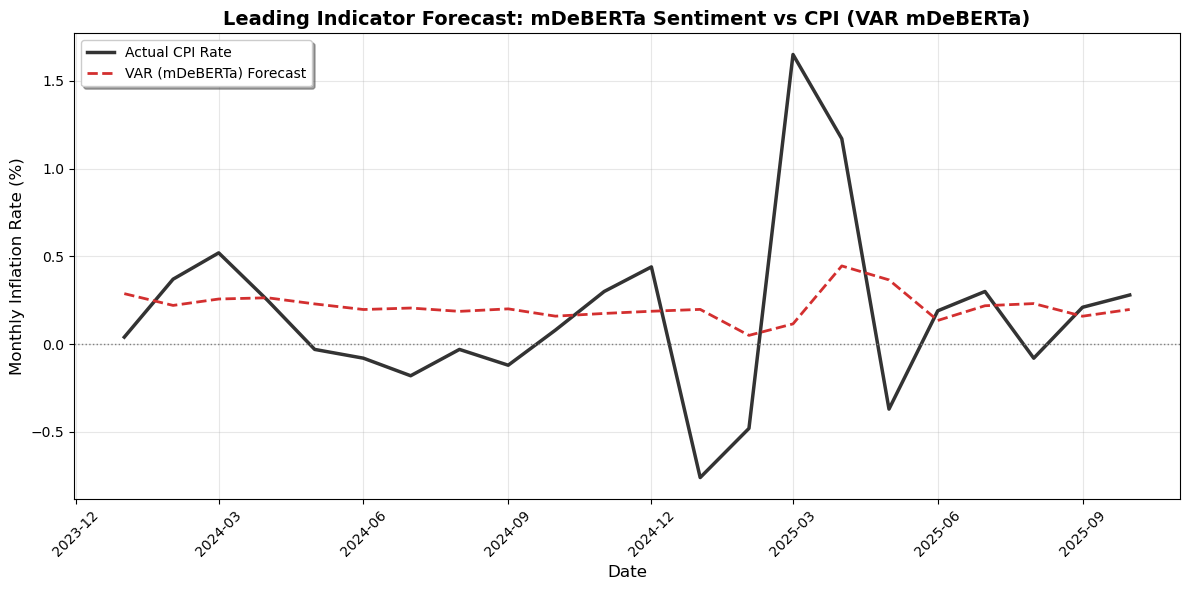

In [10]:
def plot_best_model(test_dates, y_true, y_pred, title_suffix=""):
    plt.figure(figsize=(12, 6))
    
    # Plot Actual vs Forecast
    plt.plot(test_dates, y_true, label='Actual CPI Rate', color='black', linewidth=2.5, alpha=0.8)
    plt.plot(test_dates, y_pred, label='VAR (mDeBERTa) Forecast', color='#D32F2F', linestyle='--', linewidth=2)
    
    # Highlight the "Zero Line" (Deflation/Inflation threshold)
    plt.axhline(0, color='gray', linestyle=':', linewidth=1)
    
    # Formatting
    plt.title(f"Leading Indicator Forecast: mDeBERTa Sentiment vs CPI {title_suffix}", fontsize=14, fontweight='bold')
    plt.ylabel("Monthly Inflation Rate (%)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    
    # Date formatting
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_best_model(
    test_dates=test_v.index, 
    y_true=y_test_var, 
    y_pred=y_pred_var, 
    title_suffix="(VAR mDeBERTa)"
)

The best performing model, the Bi-variate VAR, can be formalized as:
$$Y_t = c + A_1 Y_{t-1} + \dots + A_p Y_{t-p} + \epsilon_t$$
 
Where  $Y_t = [\text{Rate}_t, \text{Sentiment}_t]^T$ is a vector of endogenous variables, and p is the optimal lag order selected by BIC.

The "Leading Indicator Forecast" plot visually compares the Actual CPI Rate (black line) against the VAR mDeBERTa Forecast (red dashed line).

- Trend Capture: The model successfully captures the stable period in early 2024.
- Shock Response: There is a massive spike in actual inflation in late 2024/early 2025 (likely a specific economic shock). The forecast attempts to follow this upward trend but underestimates the magnitude.
- Conclusion: The sentiment index successfully signaled the direction of the volatility but, like most models, could not perfectly predict the amplitude of such an extreme outlier event. However, it successfully avoided false positives during the stable periods.|